### Importing the  OASIS 2 Dataset: Longitudinal Demographics

In [103]:
import pandas as pd

data = pd.read_csv("~/code/mkvph0ch/memobrain/raw_data/OASIS2/oasis_longitudinal_demographics.csv")

data[:10]

,Subject ID,MRI ID,Group,Visit,MR Delay,M/F,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,OAS2_0001,OAS2_0001_MR1,Nondemented,1,0,M,R,87,14,2.0,27.0,0.0,1987,0.696,0.883
1,OAS2_0001,OAS2_0001_MR2,Nondemented,2,457,M,R,88,14,2.0,30.0,0.0,2004,0.681,0.876
2,OAS2_0002,OAS2_0002_MR1,Demented,1,0,M,R,75,12,NaN,23.0,0.5,1678,0.736,1.046
3,OAS2_0002,OAS2_0002_MR2,Demented,2,560,M,R,76,12,NaN,28.0,0.5,1738,0.713,1.010
4,OAS2_0002,OAS2_0002_MR3,Demented,3,1895,M,R,80,12,NaN,22.0,0.5,1698,0.701,1.034
5,OAS2_0004,OAS2_0004_MR1,Nondemented,1,0,F,R,88,18,3.0,28.0,0.0,1215,0.710,1.444
6,OAS2_0004,OAS2_0004_MR2,Nondemented,2,538,F,R,90,18,3.0,27.0,0.0,1200,0.718,1.462
7,OAS2_0005,OAS2_0005_MR1,Nondemented,1,0,M,R,80,12,4.0,28.0,0.0,1689,0.712,1.039
8,OAS2_0005,OAS2_0005_MR2,Nondemented,2,1010,M,R,83,12,4.0,29.0,0.5,1701,0.711,1.032
9,OAS2_0005,OAS2_0005_MR3,Nondemented,3,1603,M,R,85,12,4.0,30.0,0.0,1699,0.705,1.033


### Data cleaning
We check if there are any missing values in the dataset:

In [49]:
data.isnull().sum()

Subject ID     0
MRI ID         0
Group          0
Visit          0
MR Delay       0
M/F            0
Hand           0
Age            0
EDUC           0
SES           19
MMSE           2
CDR            0
eTIV           0
nWBV           0
ASF            0
dtype: int64

We create the clean_data function, that:

- Drop unneeded columns 'MR Delay', 'Subject ID', 'MRI ID', 'Group', 'Visit' and 'Hand' (all patients are right handed)
- Fill NaN values with the median in the case of 'SES' and 'MMSE' feature columns.
- Transform the target column 'CDR' into binary class, dividing into Demented (some level) and Non Demented.

In [104]:
def clean_data(data):
    data=data.drop(columns=['MR Delay', 'Subject ID', 'MRI ID', 'Group', 'Visit', 'Hand'])
    data['SES'].fillna(value=int(data.SES.median()), inplace=True)
    data['MMSE'].fillna(value=int(data.MMSE.median()), inplace=True)
    data["CDR"]=data["CDR"].apply(lambda x: 1 if x>0 else 0)
    return data

Then we split the data into X features and the y target.

In [105]:
X=clean_data(data).drop(columns=['CDR'])
y=clean_data(data)['CDR']
X

,M/F,Age,EDUC,SES,MMSE,eTIV,nWBV,ASF
0,M,87,14,2.0,27.0,1987,0.696,0.883
1,M,88,14,2.0,30.0,2004,0.681,0.876
2,M,75,12,2.0,23.0,1678,0.736,1.046
3,M,76,12,2.0,28.0,1738,0.713,1.010
4,M,80,12,2.0,22.0,1698,0.701,1.034
...,...,...,...,...,...,...,...,...
368,M,82,16,1.0,28.0,1693,0.694,1.037
369,M,86,16,1.0,26.0,1688,0.675,1.040
370,F,61,13,2.0,30.0,1319,0.801,1.331
371,F,63,13,2.0,30.0,1327,0.796,1.323


In [135]:
y.value_counts()

0    206
1    167
Name: CDR, dtype: int64

EDUC: Level of Education (6 to 23)

SES: Socioeconomic Status (1 to 5)

MMSE: Mini-Mental State Examination (4 to 30)

eTIV: Estimated total intracranial volume (mm3)

nWBV: Normalized whole brain volume

ASF: Atlas scaling factor

### Pipeline
We create a pipeline with all the transformations that will be applied to the data set, including scaling and encoding.

In [186]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.compose import make_column_transformer
from sklearn import set_config; set_config(display='diagram')
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline

preproc = ColumnTransformer([
    ('s_scaler', StandardScaler(), ['Age']),
    ('m_scaler', MinMaxScaler(), ['EDUC']),
    ('r_scaler', RobustScaler(), ['eTIV', 'MMSE']),
    ('lab_encoder', OrdinalEncoder(), ['M/F'])],
    remainder='passthrough')

preproc

ColumnTransformer(remainder='passthrough',
                  transformers=[('s_scaler', StandardScaler(), ['Age']),
                                ('m_scaler', MinMaxScaler(), ['EDUC']),
                                ('r_scaler', RobustScaler(), ['eTIV', 'MMSE']),
                                ('lab_encoder', OrdinalEncoder(), ['M/F'])])

In [189]:
OrdinalEncoder.get_feature_names_out = (lambda self, names=None: self.feature_names_in_)
oasis2_scaled=pd.DataFrame(preproc.fit_transform(X,y), columns = preproc.get_feature_names_out())
oasis2_scaled

,s_scaler__Age,m_scaler__EDUC,r_scaler__eTIV,r_scaler__MMSE,lab_encoder__M/F,remainder__SES,remainder__nWBV,remainder__ASF
0,1.308738,0.470588,2.154167,-0.666667,1.0,2.0,0.696,0.883
1,1.439787,0.470588,2.225000,0.333333,1.0,2.0,0.681,0.876
2,-0.263856,0.352941,0.866667,-2.000000,1.0,2.0,0.736,1.046
3,-0.132806,0.352941,1.116667,-0.333333,1.0,2.0,0.713,1.010
4,0.391392,0.352941,0.950000,-2.333333,1.0,2.0,0.701,1.034
...,...,...,...,...,...,...,...,...
368,0.653491,0.588235,0.929167,-0.333333,1.0,1.0,0.694,1.037
369,1.177688,0.588235,0.908333,-1.000000,1.0,1.0,0.675,1.040
370,-2.098548,0.411765,-0.629167,0.333333,0.0,2.0,0.801,1.331
371,-1.836449,0.411765,-0.595833,0.333333,0.0,2.0,0.796,1.323


\
Renaming the column labels that were modified while applying the pipeline.

In [191]:
oasis2_scaled = oasis2_scaled.rename(columns={"s_scaler__Age": "scaled_age",
                              "m_scaler__EDUC": "scaled_educ",
                              "r_scaler__eTIV": "scaled_eTIV",
                              "r_scaler__MMSE": "scaled_MMSE",
                              "lab_encoder__M/F": "male",
                              #"lab_encoder__M/F_M": "male",
                              "remainder__SES": "SES",
                              "remainder__nWBV": "nWBV",
                              "remainder__ASF": "ASF"})

oasis2_scaled

,scaled_age,scaled_educ,scaled_eTIV,scaled_MMSE,male,SES,nWBV,ASF
0,1.308738,0.470588,2.154167,-0.666667,1.0,2.0,0.696,0.883
1,1.439787,0.470588,2.225000,0.333333,1.0,2.0,0.681,0.876
2,-0.263856,0.352941,0.866667,-2.000000,1.0,2.0,0.736,1.046
3,-0.132806,0.352941,1.116667,-0.333333,1.0,2.0,0.713,1.010
4,0.391392,0.352941,0.950000,-2.333333,1.0,2.0,0.701,1.034
...,...,...,...,...,...,...,...,...
368,0.653491,0.588235,0.929167,-0.333333,1.0,1.0,0.694,1.037
369,1.177688,0.588235,0.908333,-1.000000,1.0,1.0,0.675,1.040
370,-2.098548,0.411765,-0.629167,0.333333,0.0,2.0,0.801,1.331
371,-1.836449,0.411765,-0.595833,0.333333,0.0,2.0,0.796,1.323


\
We now split the data into train and test set.

In [192]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(oasis2_scaled, y, test_size=0.25, random_state=42)

\
We will create now a Decision Tree, to break down the data through binary decisions.

In [120]:
from sklearn.tree import DecisionTreeClassifier
tree_clf = DecisionTreeClassifier(max_depth=2, random_state=2)
tree_clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=2, random_state=2)

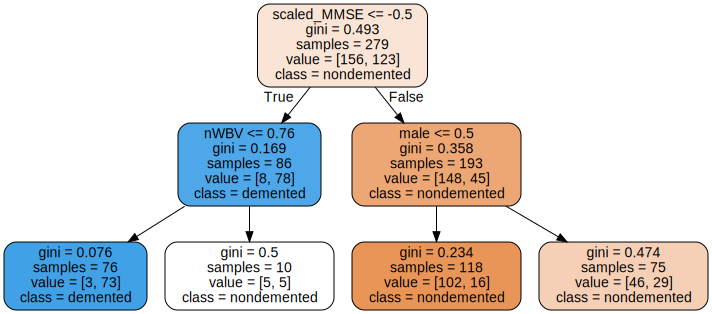

In [123]:
import graphviz

from sklearn.tree import export_graphviz
export_graphviz(tree_clf, out_file="dt.dot", 
                feature_names=X_train.columns,
                class_names=['nondemented','demented'], 
                rounded=True, filled=True)

with open("dt.dot") as f:
    dot_graph = f.read()
    display(graphviz.Source(dot_graph))

In [221]:
from sklearn.model_selection import GridSearchCV

parameters = {'criterion': ['gini', 'entropy'],
              'max_depth': range(1,10),
              'min_samples_leaf': range(1,10),
              'min_samples_split': range(2,10)}
gridsearch = GridSearchCV(DecisionTreeClassifier(),
                          parameters,
                          n_jobs=-1,
                          cv=5,
                          scoring="recall")

gridsearch.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(1, 10),
                         'min_samples_leaf': range(1, 10),
                         'min_samples_split': range(2, 10)},
             scoring='recall')

In [239]:
gridsearch.best_params_

{'criterion': 'entropy',
 'max_depth': 8,
 'min_samples_leaf': 3,
 'min_samples_split': 5}

In [240]:
gridsearch.best_score_

0.7733333333333333

Improving the Decision Tree

In [235]:
tree_clf2 = DecisionTreeClassifier(criterion= 'entropy', max_depth=8, min_samples_leaf= 3, min_samples_split= 5)
tree_clf2.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=8, min_samples_leaf=3,
                       min_samples_split=5)

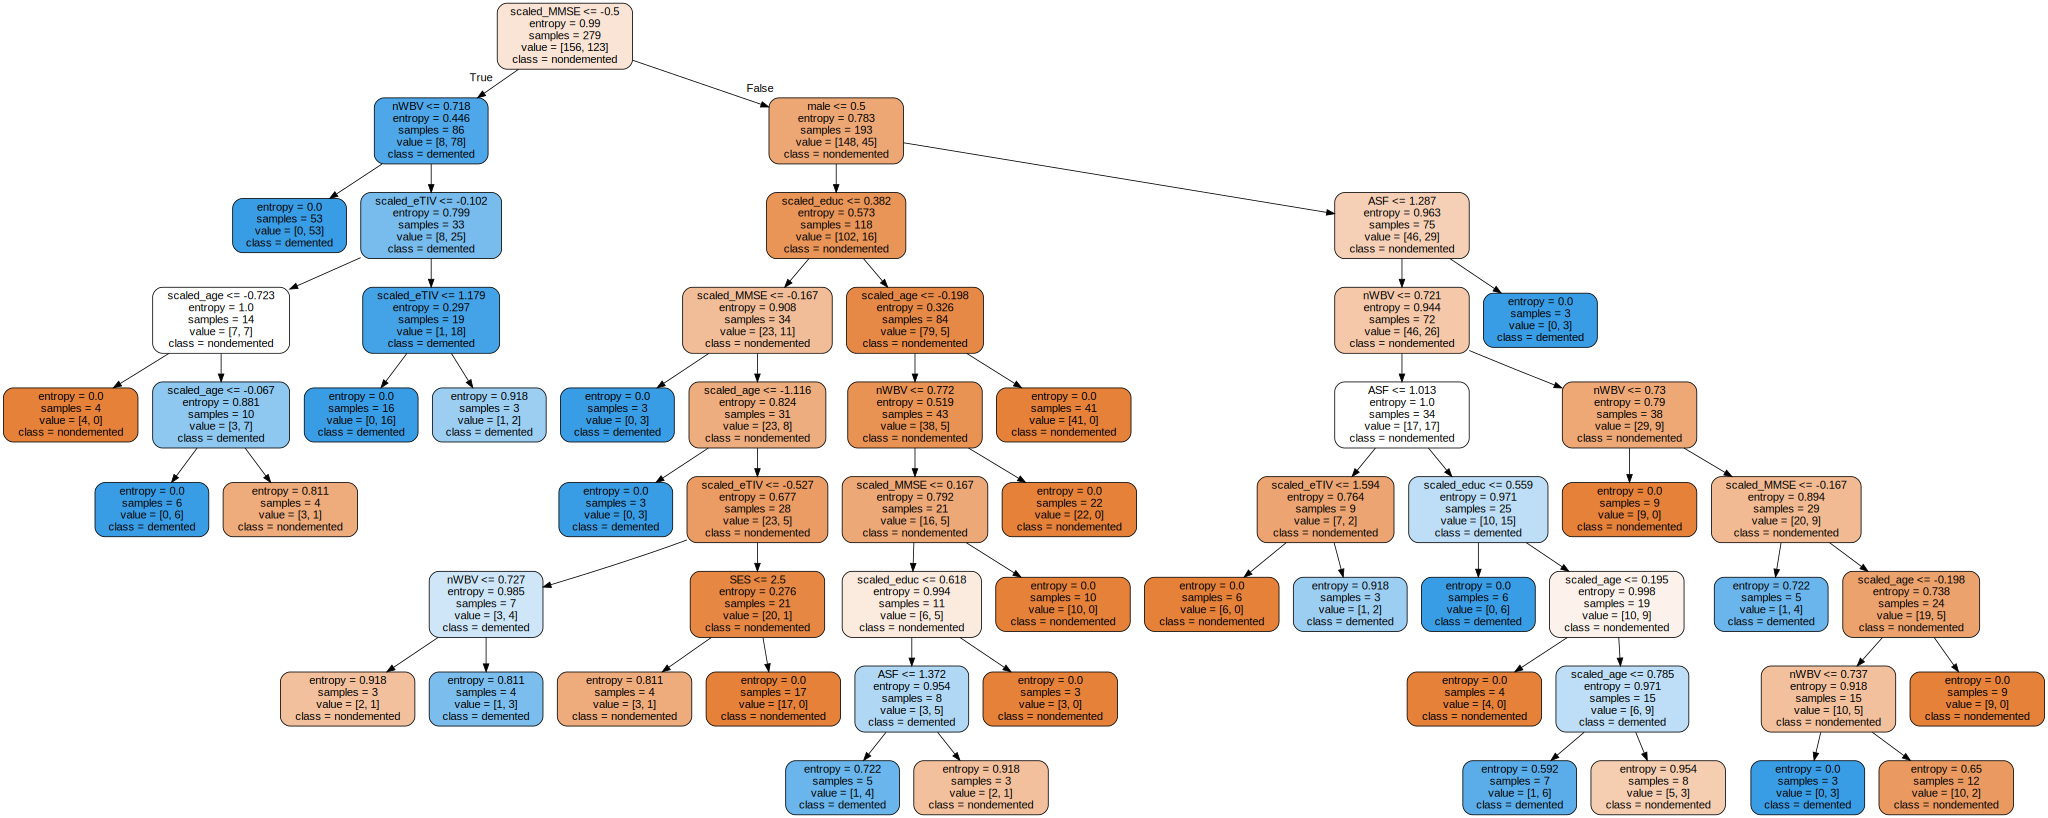

In [236]:
import graphviz

from sklearn.tree import export_graphviz
export_graphviz(tree_clf2, out_file="dt2.dot", 
                feature_names=X_train.columns,
                class_names=['nondemented','demented'], 
                rounded=True, filled=True)

with open("dt2.dot") as f:
    dot_graph = f.read()
    display(graphviz.Source(dot_graph))

\
Now we will predict the target:

In [237]:
y_pred = tree_clf2.predict(X_test)

And compare this prediction with the real values:

In [238]:
np.unique(y_test, return_counts=True), np.unique(y_pred, return_counts=True)

((array([0, 1]), array([50, 44])), (array([0, 1]), array([50, 44])))

y_true: 50 non demented,  44 demented \
y_pred: 49 non demended,  45 demented

In [234]:
from sklearn.metrics import recall_score
recall_score(y_test, y_pred)

0.7272727272727273